In [ ]:
import torch

# probabilistic programming
import pyro 

# MCMC plotting
import arviz as az
import matplotlib.pyplot as plt
from getdist.arviz_wrapper import arviz_to_mcsamples
from getdist import plots

# autoemulate imports
from autoemulate.simulations.epidemic import Epidemic
from autoemulate.core.compare import AutoEmulate
from autoemulate.calibration.bayes import BayesianCalibration
from autoemulate.calibration.evidence import EvidenceComputation
from autoemulate.emulators import GaussianProcessRBF

# suppress warnings in notebook for readability
import os
import warnings

# ignore warnings
warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

# random seed for reproducibility
random_seed = 42

In [23]:
from autoemulate.data.utils import set_random_seed
set_random_seed(random_seed)
pyro.set_rng_seed(random_seed)

# Bayesian calibration

Bayesian calibration is a method for estimating which input parameters were most likely to produce observed data. An advantage over other calibration methods is that it returns a probability distribution over the input parameters rather than just point estimates.

Performing Bayesian calibration requires:
- a simulator or an emulator trained to approximate the simulator
- observations associated with the simulator/emulator output



## 1. Simulate data

In this example, we'll use the `Epidemic` simulator, which returns the peak infection rate given two input parameters, `beta`(the transimission rate per day) and `gamma` (the recovery rate per day).

In [24]:
simulator = Epidemic(log_level="error")
x = simulator.sample_inputs(1000)
y, _ = simulator.forward_batch(x)

INFO:autoemulate:Running batch simulation for 1000 samples
DEBUG:autoemulate:Running simulation for sample 1/1000
DEBUG:autoemulate:Running simulation for sample 1/1000
DEBUG:autoemulate:Simulation 1/1000 successful
DEBUG:autoemulate:Running simulation for sample 2/1000
DEBUG:autoemulate:Simulation 2/1000 successful
DEBUG:autoemulate:Running simulation for sample 3/1000
DEBUG:autoemulate:Simulation 3/1000 successful
DEBUG:autoemulate:Running simulation for sample 4/1000
DEBUG:autoemulate:Simulation 1/1000 successful
DEBUG:autoemulate:Running simulation for sample 2/1000
DEBUG:autoemulate:Simulation 2/1000 successful
DEBUG:autoemulate:Running simulation for sample 3/1000
DEBUG:autoemulate:Simulation 3/1000 successful
DEBUG:autoemulate:Running simulation for sample 4/1000
DEBUG:autoemulate:Simulation 4/1000 successful
DEBUG:autoemulate:Running simulation for sample 5/1000
DEBUG:autoemulate:Simulation 5/1000 successful
DEBUG:autoemulate:Running simulation for sample 6/1000
DEBUG:autoemula

Below we plot the simulated data. The peak infection rate is higher when the transmission rate increases and the recovery rate decreases and the two parameters are correlated with each other.

<function matplotlib.pyplot.show(close=None, block=None)>

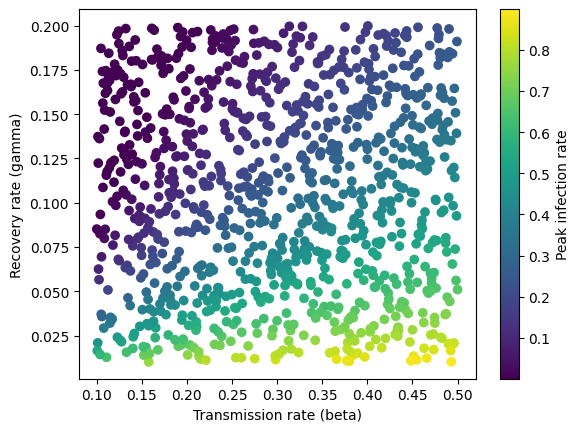

In [25]:
transmission_rate = x[:, 0]
recovery_rate = x[:, 1]

plt.scatter(transmission_rate, recovery_rate, c=y, cmap='viridis')
plt.xlabel('Transmission rate (beta)')
plt.ylabel('Recovery rate (gamma)')
plt.colorbar(label="Peak infection rate")
plt.show

Calibration requires at least one or multiple observations. These can come from running experiments or from the literature.

Below we pick the initial parameter values and simulate the output. We then add noise to generate 100 "observations". 

In [26]:
true_beta = 0.3
true_gamma = 0.15 

# simulator expects inputs of shape [1, number of inputs]
params = torch.tensor([true_beta, true_gamma]).view(1, -1)
true_infection_rate = simulator.forward(params)

n_obs = 100
stdev = 0.05
noise = torch.normal(mean=0, std=stdev, size=(n_obs,))
observed_infection_rates = true_infection_rate[0] + noise

observations = {"infection_rate": observed_infection_rates}

We can now use these observations to infer which input parameters were most likely to have produced them.

## 2. Calibrate with simulator

In this example, we have a fast simulator with only two input parameters, so we can use the simulator for calibration. The below code shows how to do this directly with Pyro. We can then compare this approach with using an emulator for calibration.

In [27]:
import pyro.distributions as dist
from pyro.infer import MCMC
from pyro.infer.mcmc import RandomWalkKernel

# define the probabilistic model
def model():
    # uniform priors on parameters range
    beta = pyro.sample("beta", dist.Uniform(0.1, 0.5))
    gamma = pyro.sample("gamma", dist.Uniform(0.01, 0.2))
    
    mean = simulator.forward(torch.tensor([[beta, gamma]]))

    with pyro.plate(f"data", n_obs):
        pyro.sample(
            "infection_rate",
            dist.Normal(mean, stdev),
            obs=observations["infection_rate"],
        )

# run Bayesian inference with MCMC


kernel = RandomWalkKernel(model, init_step_size=2.5)
mcmc_sim = MCMC(
    kernel,
    warmup_steps=500,
    num_samples=5000,
    num_chains=1
)
mcmc_sim.run()


Sample: 100%|██████████| 5500/5500 [00:08, 630.68it/s, step size=1.07e+00, acc. prob=0.038]


Below we plot the posterior samples of the input parameters.

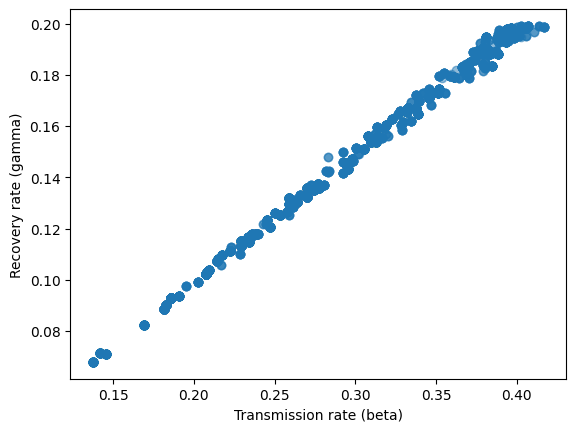

In [28]:
sim_samples = mcmc_sim.get_samples()
    
plt.scatter(sim_samples['beta'], sim_samples['gamma'], alpha=0.5)
plt.xlabel('Transmission rate (beta)')
plt.ylabel('Recovery rate (gamma)')
plt.show()

## 3. Calibrate with emulator

For more complex simulators, it is recommended to first train an emulator to approximate the simulator and then use the emulator for calibration. This is because calibration typically requires thousands of evaluations of the simulator, which can be computationally expensive.

`AutoEmulate` provides the `BayesCalibrator` class to perform Bayesian calibration with an emulator.

First we need to train an emulator. For the purposes of this tutorial, we will restrict the emulator choice to `GaussianProcess` with default hyperparameters.

In [29]:
ae = AutoEmulate(
    x, 
    y, 
    models=[GaussianProcessRBF], 
    # use default parameters
    model_params={},
    log_level="error",
    device="cpu",  
)

INFO:autoemulate:Comparing ['GaussianProcessRBF']
INFO:autoemulate:Running Model: GaussianProcessRBF: 1/1 (attempt 1/3)
DEBUG:autoemulate:Skipping tuning for model "GaussianProcessRBF", using defaultparameters
DEBUG:autoemulate:Running cross-validation for model "GaussianProcessRBF" for "10" iterations
INFO:autoemulate:Running Model: GaussianProcessRBF: 1/1 (attempt 1/3)
DEBUG:autoemulate:Skipping tuning for model "GaussianProcessRBF", using defaultparameters
DEBUG:autoemulate:Running cross-validation for model "GaussianProcessRBF" for "10" iterations
DEBUG:autoemulate:Cross-validation for model "GaussianProcessRBF" completed with test metrics: r2: 1.000 (std: 0.000), rmse: 0.001 (std: 0.000)
INFO:autoemulate:Finished running Model: GaussianProcessRBF

INFO:autoemulate:Using metric 'r2' to determine best result.
DEBUG:autoemulate:Comparison results:
Best Model: GaussianProcessRBF, x transforms: [StandardizeTransform()], y transforms: [StandardizeTransform()], Best params: {'likelihood_

We can verify that the fitted emulator performs well on both the train and test data.

In [30]:
ae.summarise()

,model_name,x_transforms,y_transforms,params,r2_test,r2_test_std,rmse_test,rmse_test_std,r2_train,r2_train_std,rmse_train,rmse_train_std
0,GaussianProcessRBF,[StandardizeTransform()],[StandardizeTransform()],{'likelihood_cls': <class 'gpytorch.likelihood...,0.999978,0.000004,0.001205,0.000103,0.999977,0.000002,0.001101,0.000057


In [31]:
gp = ae.best_result().model

INFO:autoemulate:Using metric 'r2' to determine best result.


The `BayesianCalibration` object takes as input the trained emulator, the simulator parameter ranges and the "observed" data simulated above. 

The underlying probabilistic model is the same one used on the simulator example above. It assumes the observations are drawn from a Gaussian distribution with the mean predicted by the emulator. The user also has to specify the `observation_noise` which is the variance of the Gaussian likelihood.

In [32]:
bc = BayesianCalibration(
    gp, 
    simulator.parameters_range, 
    observations, 
    # specify noise as variance
    observation_noise=stdev**2
)

INFO:autoemulate:Initializing BayesianCalibration with parameters: ['beta', 'gamma']
INFO:autoemulate:Processed observations for outputs: ['infection_rate']
DEBUG:autoemulate:Observation noise (variance) set as float: 0.0025000000000000005


Run MCMC using the NUTS sampler. The `BayesianCalibration` class uses Pyro under the hood. Below we use `pyro.set_rng_seed` to ensure reproducibility.

In [33]:
mcmc_emu = bc.run_mcmc(
    warmup_steps=250, 
    num_samples=1000,
    num_chains=5    
)

DEBUG:autoemulate:Using NUTS kernel.
INFO:autoemulate:Starting MCMC run.


Warmup [1]:   0%|          | 0/1250 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1250 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/1250 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/1250 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/1250 [00:00, ?it/s]

INFO:autoemulate:MCMC run completed.


The above returns the Pyro `MCMC` object which has a number of useful methods associated with it. One can access all the posterior samples using `mcmc.get_samples()` or just the summary statistics using `mcmc.summary()`. This shows that the posterior mean estimates of the input parameters are close to the true values used to generate the observations.

In [34]:
mcmc_emu.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      0.32      0.06      0.32      0.24      0.40     15.90      1.15
     gamma      0.16      0.03      0.16      0.12      0.20     15.81      1.15

Number of divergences: 106


## 3. Plotting with Arviz

The `BayesianCalibrator.to_arviz` method converts the `mcmc` object so that it is compatible with the Arviz plotting library. Using Arviz makes it very easy to produce all the standard plots of the calibration results as well as MCMC diagnostics.

In [35]:
az_data = bc.to_arviz(mcmc_emu, posterior_predictive=True)

INFO:autoemulate:Including posterior predictive samples in Arviz output.
DEBUG:autoemulate:Posterior predictive samples generated.
DEBUG:autoemulate:Using az.from_pyro for conversion.
INFO:autoemulate:Arviz InferenceData conversion complete.


The main plot of interest is the posterior distribution over the parameters given the observations. Below we plot the pairwise joint distribution and can see that the two parameters are correlated as expected. The results look very similar to the results obtained using the simulator directly above.

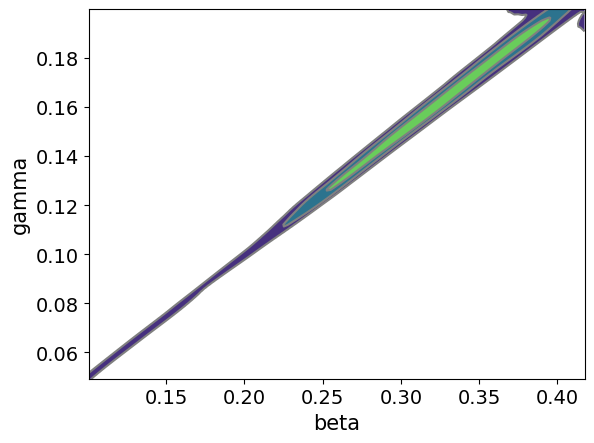

In [36]:
_ = az.plot_pair(az_data, kind='kde')

The posterior predictive samples can be plotted alongside the observed data. This shows that the calibration results capture the observed data well.

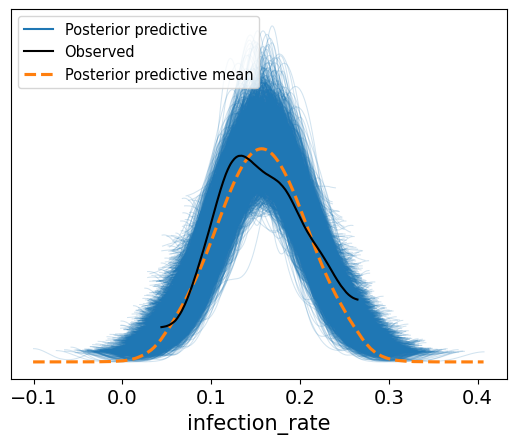

In [37]:
_ = az.plot_ppc(az_data)

To check the MCMC behaviour, the samples from the posterior distribution can be viewed as a trace (right-hand plots) with 1D KDEs for each chain for each variable (left-hand plots).

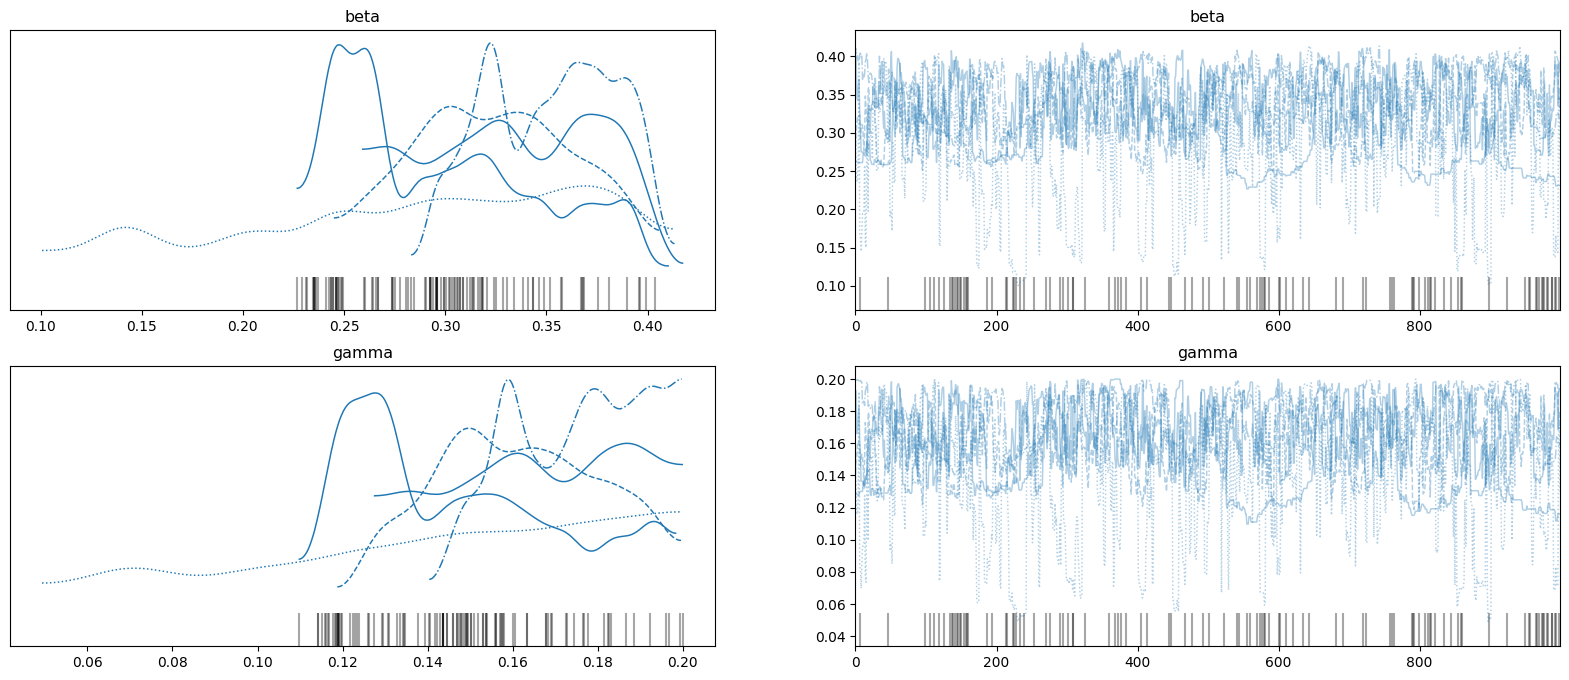

In [38]:
_ = az.plot_trace(az_data, figsize=(20, 8))

## 4. Plotting with GetDist

The `BayesianCalibration.to_getdist` static method converts an `mcmc` object so that it is compatible with the `getdist` plotting library. Alternatively, one can use the `arviz_to_mcsamples` function from GetDist to convert the Arviz data object to a GetDist `MCSamples` object. 

In [39]:
# convert simulator calibration samples
sim_data = BayesianCalibration.to_getdist(mcmc_sim, label="Simulator")

# convert emulator calibration samples
emu_data = arviz_to_mcsamples(az_data, dataset_label="Emulator")

Removed no burn in
Removed no burn in


Below we compare the posterior distributions obtained using the simulator and the emulator. Both distributions capture the true parameter values (indicated by the dashed lines). 

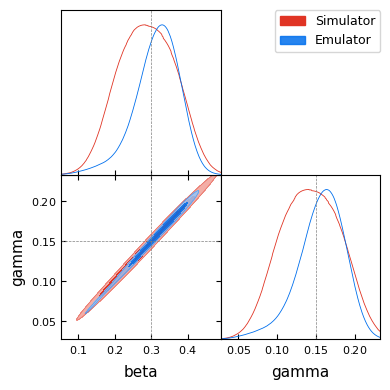

In [40]:
sim_data.smooth_scale_1D = 0.8
emu_data.smooth_scale_1D = 0.8

g = plots.get_subplot_plotter()
g.triangle_plot( 
    [sim_data, emu_data], 
    filled=True,
    markers={"beta": true_beta, "gamma": true_gamma},
)
plt.show()

# g.fig.savefig("bayes_calibration_getdist.png")

## Bayesian Evidence Computation

After calibration, we can compute the Bayesian evidence (marginal likelihood) to quantify how well the model explains the observed data. The evidence is essential for Bayesian model comparison and selection.

We use the [Harmonic](https://github.com/astro-informatics/harmonic) package, which implements a learned harmonic mean estimator with normalizing flows.

In [ ]:
# Compute evidence using the MCMC samples from emulator calibration
ec = EvidenceComputation(mcmc_emu, bc.model)
results = ec.compute_evidence(epochs=30, verbose=False)

print(f"ln(Evidence) = {results['ln_evidence']:.2f}")
print(f"Error bounds: [{results['error_lower']:.3f}, {results['error_upper']:.3f}]")
print(f"\nUsed {results['num_chains']} chains with {results['num_samples_per_chain']} samples each")
print(f"Number of parameters: {results['num_parameters']}")

INFO    2026-01-21 15:50:05,413 - autoemulate - Initializing EvidenceComputation


INFO:autoemulate:Initializing EvidenceComputation


INFO    2026-01-21 15:50:05,414 - autoemulate - Training proportion: 0.5


INFO:autoemulate:Training proportion: 0.5


INFO    2026-01-21 15:50:05,415 - autoemulate - Temperature: 0.8


INFO:autoemulate:Temperature: 0.8


INFO    2026-01-21 15:50:05,415 - autoemulate - Flow model: RQSpline


INFO:autoemulate:Flow model: RQSpline


INFO    2026-01-21 15:50:05,416 - autoemulate - Extracting log probabilities from MCMC samples...


INFO:autoemulate:Extracting log probabilities from MCMC samples...


INFO    2026-01-21 15:50:23,784 - autoemulate - Samples shape: torch.Size([5, 1000, 2])


INFO:autoemulate:Samples shape: torch.Size([5, 1000, 2])


INFO    2026-01-21 15:50:23,785 - autoemulate - Log probabilities shape: torch.Size([5, 1000])


INFO:autoemulate:Log probabilities shape: torch.Size([5, 1000])


INFO    2026-01-21 15:50:23,786 - autoemulate - EvidenceComputation initialized successfully


INFO:autoemulate:EvidenceComputation initialized successfully


INFO    2026-01-21 15:50:23,808 - autoemulate - Starting evidence computation pipeline


INFO:autoemulate:Starting evidence computation pipeline


INFO    2026-01-21 15:50:28,388 - autoemulate - Evidence: ln(Z) = 155.4328


INFO:autoemulate:Evidence: ln(Z) = 155.4328


ln(Evidence) = 155.43
Error bounds: [-0.057, 0.054]

Used 5 chains with 1000 samples each
Number of parameters: 2
